# Statistical analysis of the generated cell positions

This notebook contains some codes that analyze the cell position data generated from pycabnn.

In [4]:
import numpy as np
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


## Load data

Here we load the sample cell position data.

In [5]:
# A few utility functions to p

def limit_to_box(x, box):
    """select only the points within a given box."""
    mf = x.copy()
    for i, t in enumerate(box):
        mf = mf[mf[:, i] >= t[0], :]
        mf = mf[mf[:, i] <= t[1], :]
    return mf

def print_range(goc):
    """prints the 3d range occupied by the cell population"""
    print(
        "Current range:\n",
        "x: [{}, {}]\n".format(goc[:, 0].min(), goc[:, 0].max()),
        "y: [{}, {}]\n".format(goc[:, 1].min(), goc[:, 1].max()),
        "z: [{}, {}]".format(goc[:, 2].min(), goc[:, 2].max()),
    )

def fix_coords(x, bbox):
    """removes the cells in a 25 um-wide gutter."""
    y = x - 25
    y = limit_to_box(y, bbox)
    print_range(y)
    return y


In [6]:
# load the data
fname = "../../test_data/generated_positions/coords_20190626_1_6.npz"
f = np.load(fname)
f['grc_nop'].shape # grc_nop is grc positions without perturbation

# readjuct the data to the bounding box - note that the data were generated in a larger volume
bbox = [[0, 700], [0, 700], [0, 200]]
grc = fix_coords(f['grc_nop'], bbox) # here we use the unperturbed position
glo = fix_coords(f['glo'], bbox)
grx = grc + np.random.randn(*grc.shape)*0.2 # add perturbation, corresponding to the softness margin, 0.2 um here.


Current range:
 x: [0.008738726727301582, 699.9951413085064]
 y: [0.0056677228167814064, 699.9989124811175]
 z: [0.0020255851778578915, 199.99996645157134]
Current range:
 x: [0.0003566497912323996, 699.9434720937548]
 y: [0.03680411733359179, 699.9969905094972]
 z: [0.0011508231361929688, 199.98956118528915]


## GrC position analysis

### Nearest neighbor histogram

Here we draw the nearest neighbor distance histogram (Fig. 4B)

In [7]:
nn = NearestNeighbors()
nn.fit(grx)
dists, nnids = nn.kneighbors(grx, n_neighbors=2, return_distance=True)

nn.fit(grc)
dists_u, nnids = nn.kneighbors(grc, n_neighbors=2, return_distance=True)

nnids = nnids[:,1]
dists = dists[:,1]

dists_u = dists_u[:,1]

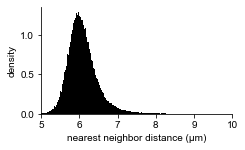

In [8]:
_, ax = plt.subplots(figsize=(8.9/2.54, 8.9/2.54*5/8))
ax.hist(dists, 450, density=True, color='k')

ax.set(
    xlim=[5, 10],
    xlabel='nearest neighbor distance (μm)',
    ylabel='density'
)
plt.tight_layout()
plt.savefig('nn_dist_hist.png', dpi=600)

### Pair correlation function

Here are the codes for computing the pair correlation function (Fig. 4C)

In [9]:
# we limit the calculation to "inside" cells to avoid the boundary effect.
gry = limit_to_box(grx, [[30, 670], [30, 670], [30, 170]])

nn = NearestNeighbors(n_jobs=-1)
nn.fit(grx)

mcounts = []
sdcounts = []
dists = np.linspace(0, 30, 240)
for r in tqdm(dists):
    count = np.frompyfunc(lambda x: x.size, 1, 1)(nn.radius_neighbors(
        gry, radius=r, return_distance=False
    )).astype(float) - 1
    mcounts.append(count.mean())
    sdcounts.append(count.std()/np.sqrt(count.size))

# mcount = count.mean()
# sdcount = count.std()
# print('{} ± {}'.format(mcount, sdcount))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


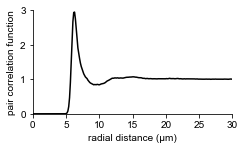

In [10]:
cc2 = np.gradient(mcounts)/(dists**2)
cc2_0 = cc2[-1]
cc2 = cc2/cc2_0

mcounts = np.array(mcounts)
sdcounts = np.array(sdcounts)

cc2_u = np.gradient(mcounts + 150*sdcounts)/(dists**2+0.001)/cc2_0
cc2_d = np.gradient(mcounts - 150*sdcounts)/(dists**2+0.001)/cc2_0

_, ax = plt.subplots(figsize=(8.9/2.54, 8.9/2.54*5/8))
ax.plot(dists, cc2, 'k')
ax.set(
    ylim = [0, 3],
    xlim = [0, 30],
    xlabel='radial distance (μm)',
    ylabel='pair correlation function'
)
plt.tight_layout()
plt.savefig('cc2_grc.png', dpi=600)

### Anglular distribution

Here we check that the nearest neighbor of each granule cell is preferentially positioned in the sagittal direction, as in the human data.

In [11]:
nn.fit(grx)
gry = limit_to_box(grx, [[30, 670], [30, 670], [30, 170]])
nnids = nn.kneighbors(gry, n_neighbors=2, return_distance=False)
nnids = nnids[:,1]

In [12]:
# print(grx.shape)
# print(gry.shape)
nn_gry = grx[nnids,:]
dvec = nn_gry-gry
dvec

from numpy.linalg import norm
dst_dvec = norm(dvec, axis=-1)
dvec2 = dvec[:,0:2]
l2_dvec2 = norm(dvec2, axis=-1)

cos_theta = dvec2[:,0]/l2_dvec2
sin_theta = dvec2[:,1]/l2_dvec2

theta = np.arctan2(sin_theta, cos_theta)

Text(0.5, 0, 'angle from sagittal')

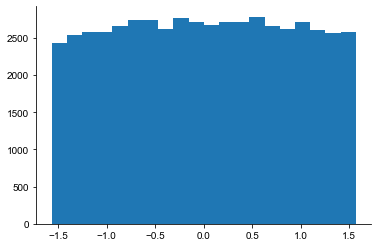

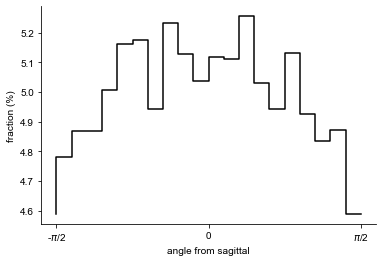

In [13]:
xx = np.linspace(-np.pi/2, np.pi/2, 21)
n, x, _ = plt.hist((theta), xx)

xtickloc = np.linspace(-np.pi/2, np.pi/2, 3)
n = n/sum(n)*100
_, ax = plt.subplots()
# ax.bar(x[:-1], n)
ax.step(x, np.hstack([n, n[0]]), 'k')
# ax.set_ylim([2050, 2300])
ax.set_xticks(xtickloc)
ax.set_xticklabels([r'-$\pi$/2', '0', r'$\pi$/2'])
ax.set_ylabel('fraction (%)')
ax.set_xlabel('angle from sagittal')

In [15]:
# Compute the excess nearest neighbor count in the sagittal direction
print(f'{(n.max()-n.min())/n.min()*100} %')

14.520773344302759 %


## Simple distance-based GrC-Glo connection

Here we demonstrate and analyze the GrC-glomerulus connectivity based on the simple distance-based rule.

## Pycabnn-generated cell position

In [16]:
scale_factor = 1/4

src = grx.copy()
tgt = glo.copy()
src[:, 1] *= scale_factor
tgt[:, 1] *= scale_factor

N conns = 4.4299305337498005 ± 1.3655061061100664


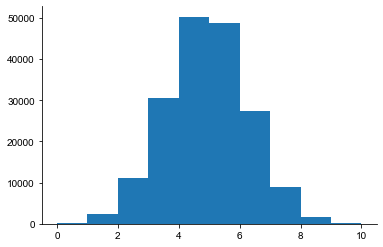

In [17]:
rr = 7.85
nn = NearestNeighbors()
nn.fit(tgt)
conns = nn.radius_neighbors(src, radius=rr, return_distance=False)
nconns = np.frompyfunc(lambda x: x.size, 1, 1)(conns).astype(int)

n_r, x_r, _ = plt.hist(nconns,np.arange(nconns.max()),100)
print('N conns = {} ± {}'.format(np.mean(nconns), np.std(nconns)))
      
# conns = nn.kneighbors(src, n_neighbors=2, return_distance=False)

## Random cell position

The same connectivity analysis with the purely random cell positions. The result can be slightly different from the numbers that we reported in the paper --- since it is random!

In [20]:
# generate the purely rarndom cell position
grx = np.random.rand(*grx.shape)
glo = np.random.rand(*glo.shape)

grx[:,0] *= 700
grx[:,1] *= 700
grx[:,2] *= 200

glo[:,0] *= 700
glo[:,1] *= 700
glo[:,2] *= 200

scale_factor = 1/4

# grx = grc + np.random.randn(*grc.shape)*0.2

src = grx.copy()
tgt = glo.copy()
src[:, 1] *= scale_factor
tgt[:, 1] *= scale_factor

N conns = 4.238801941309006 ± 2.099390143368081


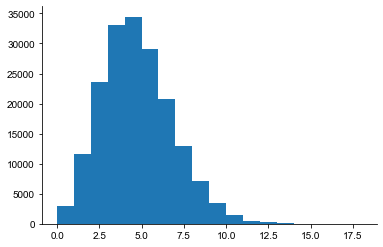

In [21]:
nn = NearestNeighbors()
nn.fit(tgt)
conns = nn.radius_neighbors(src, radius=rr, return_distance=False)
nconns = np.frompyfunc(lambda x: x.size, 1, 1)(conns).astype(int)
nc, xc, _ = plt.hist(nconns, np.arange(nconns.max()), 100)
print('N conns = {} ± {}'.format(np.mean(nconns), np.std(nconns)))